In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
messages = pd.read_csv('smsspamcollection/SMSSpamCollection', sep='\t',
                           names=["label", "message"])
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [3]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4

In [4]:
# messages.groupby('message').describe()

In [5]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x117757f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1178f6208>], dtype=object)

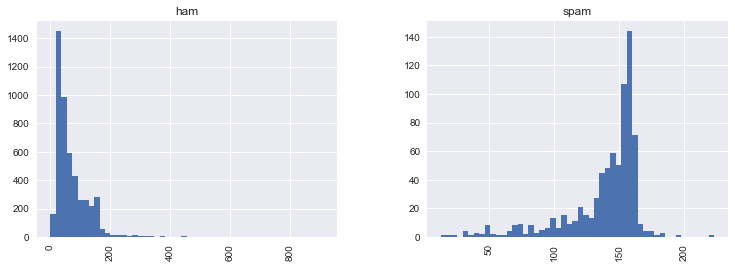

In [6]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4))

In [7]:
messages.groupby(['label'])['length'].max()

label
ham     910
spam    223
Name: length, dtype: int64

In [8]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

In [9]:
messages[messages.length == 910].message.iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

#### Data Normalization (Filteration)

In [10]:
from nltk.corpus import stopwords



import string
def normalize_text(p_message):
    nopunc = [char for char in p_message if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return ' '.join(word for word in nopunc.split() if word not in stopwords.words('english'))

In [11]:
messages['TEXT'] = messages['message'].apply(normalize_text)

In [12]:
messages.head()

,label,message,length,TEXT
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,Free entry 2 wkly comp win FA Cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,49,U dun say early hor U c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,Nah I dont think goes usf lives around though


#### Data Split
We should do the data splitting before data vectorization

In [13]:
from sklearn.model_selection import train_test_split

msg_train, msg_test, label_train, label_test = \
train_test_split(messages['message'], messages['label'], test_size=0.3)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))
# msg_train

3900 1672 5572


#### Data Pipeline
The model will be trained using Naive Bayes classifier

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=normalize_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

#### Training Model

In [18]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer=<function normalize_text at 0x117b518c8>,
        binary=False, decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=Non...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

#### Prediction

In [19]:
predictions = pipeline.predict(msg_test)
predictions

array(['spam', 'ham', 'ham', ..., 'ham', 'ham', 'ham'], 
      dtype='<U4')

#### Model Evaluation

In [20]:
from sklearn.metrics import classification_report
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

        ham       0.98      0.97      0.98      1455
       spam       0.84      0.88      0.86       217

avg / total       0.96      0.96      0.96      1672



#### Training using Logistic Regression Model

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pipeline2 = Pipeline([
    ('bow', CountVectorizer(analyzer=normalize_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ Logistic Regression
])
pipeline2.fit(msg_train,label_train)
predictions2 = pipeline2.predict(msg_test)

from sklearn.metrics import classification_report
print(classification_report(predictions2,label_test))

             precision    recall  f1-score   support

        ham       1.00      0.98      0.99      1464
       spam       0.89      0.97      0.93       208

avg / total       0.98      0.98      0.98      1672



In [22]:
message = "Free entry in 2 a wkly comp to win FA Cup"
pipeline2.predict([message])[0]

'ham'

#### Training using Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

pipeline3 = Pipeline([
    ('bow', CountVectorizer(analyzer=normalize_text)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', DecisionTreeClassifier()),  # train on TF-IDF vectors w/ Logistic Regression
])
pipeline3.fit(msg_train,label_train)
predictions3 = pipeline3.predict(msg_test)

from sklearn.metrics import classification_report
print(classification_report(predictions3,label_test))

             precision    recall  f1-score   support

        ham       0.98      0.99      0.99      1423
       spam       0.95      0.87      0.91       249

avg / total       0.97      0.97      0.97      1672



In [26]:
messages_test = ['For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. Ts www.txt-2-shop.com custcare 08715705022, 1x150p/wk',
                 "Hi mate r u coming to the pub this evening?",
                 "Hi mate r u comin?",
                 "You have an important customer service announcement from PREMIER. Call FREEPHONE 0800 542 0578 now!",
                 "K.k:)when are you going?",
                 "HAPPY NEW YEAR MY NO.1 MAN",
                 "1000's flirting NOW! Txt GIRL or BLOKE & ur NAME & AGE, eg GIRL ZOE 18 to 8007 to join and get chatting!",
                 "Dear customer .. This week end you may win a prize of 15000 NIS .. Be the winner .. ",
                 "please call 999923112312 email: rrtt@mico.com",
                 "For more information, please call 999923112312 email: rrtt@mico.com",
                 "Hi Dr Abed .. I wish you a happy Eid holiday"]
                    
for i, message in enumerate(messages_test):
    print(i, message, 'NB:', pipeline.predict([message])[0], 'LogReg:', pipeline2.predict([message])[0], 'DT:', pipeline3.predict([message])[0])
    print('\n****************************************************\n')

0 For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. Ts www.txt-2-shop.com custcare 08715705022, 1x150p/wk NB: spam LogReg: spam DT: spam

****************************************************

1 Hi mate r u coming to the pub this evening? NB: ham LogReg: ham DT: ham

****************************************************

2 Hi mate r u comin? NB: ham LogReg: ham DT: ham

****************************************************

3 You have an important customer service announcement from PREMIER. Call FREEPHONE 0800 542 0578 now! NB: spam LogReg: spam DT: spam

****************************************************

4 K.k:)when are you going? NB: ham LogReg: ham DT: ham

****************************************************

5 HAPPY NEW YEAR MY NO.1 MAN NB: ham LogReg: ham DT: ham

****************************************************

6 1000's flirting NOW! Txt GIRL or BLOKE & ur NAME & AGE, eg GIRL ZOE 18 to 8007 to join and get chatting! NB: spam LogReg: spam DT: spam

********

In [28]:
from ipywidgets import widgets
from IPython.display import display

caption = widgets.Label('Enter an article here:')
text = widgets.Textarea()
button = widgets.Button(description="Classify")
display(caption,text,button)

def handle_submit(sender):
    message = text.value
    print('NB:', pipeline.predict([message])[0], 'LogReg:', pipeline2.predict([message])[0], 'DT:', pipeline3.predict([message])[0])

button.on_click(handle_submit)

# Hi mate ... do we have class tomorrow

NB: ham LogReg: ham DT: ham
